# Overview

## Nodule candidate detection 
According to *Cheng et al* **Deep Convolution Neural Networks for Pulmonary Nodule Detection in CT imaging**   
Prerequisites   

The notebook **dicom full-preprocessing (misc1) - all patients.ipynb** preprocess the LIDC dataset into 3D volumes   
The notebook **build volume reconstructions from dicom full-preprocessing.ipynb** process the 3D volumes and creates 80x80x80 cubes and masks 

1. **v4.** 
    1. We use the dice loss from https://github.com/milesial/Pytorch-UNet/blob/master/dice_loss.py
    1. We split the data in train and test sets from patients not cubes 
1. **v2.** 
    1. We use a new version of the BCEloss2D according to https://www.kaggle.com/mlagunas/naive-unet-with-pytorch-tensorboard-logging   
1. **v1.** 
    1. We use CrossEntropyLoss instead of dice loss. (In the code we added a new version of dice, but we are not using it at the moment)   
1. **v0.** 
    1. V0 Loading the cubes from a sparse representation


## Points to check

<div class=new>
    
- Check that the skip connections are in the correct layer   
    
- The diagram has 4 blocks going down that reduces the input (80 /(2^4)=5). If we want to concatenate the skip3 with the first block going up we have to upsample times 4   

- Maybe Add Gaussian filter and random cropping
<div>

# Imports

In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook as tqdm
import matplotlib.pyplot as plt
import os
import sys
import time
from scipy.stats import mode
from scipy.stats import entropy
import pickle
import matplotlib.patches as mpatches
%matplotlib inline

In [2]:
import itertools
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset
from torch.utils.data import Dataset, DataLoader
from torch import Tensor
# from torchvision import transforms 
import torch
from torch.autograd import Variable
from torch import optim
# from torchvision import models
from torch import utils
from torchsummary import summary
torch.manual_seed(1)

In [3]:
# from torchsample.samplers import StratifiedSampler
from torch.utils.data import Sampler, WeightedRandomSampler

In [4]:
from sklearn.model_selection import train_test_split
from skimage import measure, morphology
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

In [5]:
from IPython.core.display import HTML
def css_styling():
    styles = open("../css_styles/jupyter_css_styles_1.css", "r").read()
    return HTML(styles)
css_styling()

# Functions

In [6]:
def plot_3d(image, threshold=-300, alpha=.70, fig_size=10):
    
    # Position the scan upright, 
    # so the head of the patient would be at the top facing the camera
    p = image.transpose(2,1,0)
    
    verts, faces, x,y = measure.marching_cubes(p, threshold)

    fig = plt.figure(figsize=(fig_size, fig_size))
    ax = fig.add_subplot(111, projection='3d')

    # Fancy indexing: `verts[faces]` to generate a collection of triangles
    mesh = Poly3DCollection(verts[faces], alpha=alpha)
    face_color = [0.45, 0.45, 0.75]
    mesh.set_facecolor(face_color)
    ax.add_collection3d(mesh)

    ax.set_xlim(0, p.shape[0])
    ax.set_ylim(0, p.shape[1])
    ax.set_zlim(0, p.shape[2])

    plt.show()

# Data loading

In [7]:
version = 'v4'
path_source=f'/data/OMM/Datasets/LIDC_other_formats/LIDC 3D reconstruction 80px v4 - with coords/'
GPU=1

In [8]:
files = os.listdir(f'{path_source}lungs/')
files = np.sort(files)
len(files)

28327

In [9]:
files_ids = [i.split('_cube')[0] for i in files]
files_ids = np.unique(files_ids)
files_ids = np.sort(files_ids)

In [10]:
fold = 1
batchsize = 8
files_ids_train, files_ids_test = train_test_split(files_ids, test_size=0.2, random_state=fold)
files_ids_test = np.sort(files_ids_test)
files_ids_train = np.sort(files_ids_train)
files_test = [i for i in files if i.split('_cube')[0] in files_ids_test]
files_train = [i for i in files if i.split('_cube')[0] in files_ids_train]

In [11]:
files_train

['LIDC-IDRI-0001_cube_000.npz',
 'LIDC-IDRI-0001_cube_001.npz',
 'LIDC-IDRI-0001_cube_002.npz',
 'LIDC-IDRI-0001_cube_003.npz',
 'LIDC-IDRI-0001_cube_004.npz',
 'LIDC-IDRI-0001_cube_005.npz',
 'LIDC-IDRI-0001_cube_006.npz',
 'LIDC-IDRI-0001_cube_007.npz',
 'LIDC-IDRI-0001_cube_008.npz',
 'LIDC-IDRI-0001_cube_009.npz',
 'LIDC-IDRI-0001_cube_010.npz',
 'LIDC-IDRI-0001_cube_011.npz',
 'LIDC-IDRI-0001_cube_012.npz',
 'LIDC-IDRI-0001_cube_013.npz',
 'LIDC-IDRI-0001_cube_014.npz',
 'LIDC-IDRI-0001_cube_015.npz',
 'LIDC-IDRI-0001_cube_016.npz',
 'LIDC-IDRI-0001_cube_017.npz',
 'LIDC-IDRI-0001_cube_018.npz',
 'LIDC-IDRI-0001_cube_019.npz',
 'LIDC-IDRI-0001_cube_020.npz',
 'LIDC-IDRI-0001_cube_021.npz',
 'LIDC-IDRI-0001_cube_022.npz',
 'LIDC-IDRI-0001_cube_023.npz',
 'LIDC-IDRI-0001_cube_024.npz',
 'LIDC-IDRI-0001_cube_025.npz',
 'LIDC-IDRI-0001_cube_026.npz',
 'LIDC-IDRI-0001_cube_027.npz',
 'LIDC-IDRI-0001_cube_028.npz',
 'LIDC-IDRI-0002_cube_000.npz',
 'LIDC-IDRI-0002_cube_001.npz',
 'LIDC-I

In [12]:
MIN_BOUND = -1000.0
MAX_BOUND = 400.0
PIXEL_MEAN = 0.25
class LIDCDataset(Dataset):
    def __init__(self, files_train, transform = False):
        self.X = [f'{path_source}lungs/{i}' for i in files_train]
        self.y = [f'{path_source}masks/{i}' for i in files_train]
        self.transform = transform
        
    def __len__(self):
        return len(self.X)
    
    def rotate_axis(self, img, mask, axes):
        """Rotate around the three axes maximum three times per axis"""
        num_rot = np.random.randint(1,4)
        img = np.rot90(img, num_rot, axes)
        mask = np.rot90(mask, num_rot, axes)
        return img, mask

    def __getitem__(self, idx):
        
        img = np.load(self.X[idx])
        mask = np.load(self.y[idx])
        
        img = img.f.arr_0
        mask = mask.f.arr_0
        
        # img = img.items()[0][1] # this was working on pytorch0.4 (?)
        # mask = mask.items()[0][1] # this was working on pytorch0.4 (?)
        
        if self.transform:
            if np.random.rand() > 0.5:
                img, mask = self.rotate_axis(img, mask, (0,1))
            if np.random.rand() > 0.5:
                img, mask = self.rotate_axis(img, mask, (0,2))
            if np.random.rand() > 0.5:
                img, mask = self.rotate_axis(img, mask, (1,2))
                
            # Maybe Add Gaussian filter !!!
            # Maybe Add random cropping !!!
            
        # Normalize https://www.kaggle.com/gzuidhof/full-preprocessing-tutorial
        img = (img - MIN_BOUND) / (MAX_BOUND - MIN_BOUND)
        img[img>1] = 1.
        img[img<0] = 0.
        
        # Zero center https://www.kaggle.com/gzuidhof/full-preprocessing-tutorial
        # The mean was obtained using curate the 3D reconstructed 80px data.ipynb
        img = img - PIXEL_MEAN
        
        # Add channels dimension
        img = np.expand_dims(img,0)
        mask = np.expand_dims(mask,0)
        
        mask = np.float32(mask)
        img = np.float32(img)
        
        img = torch.from_numpy(img)
        mask = torch.from_numpy(mask)
        #target = torch.from_numpy(np.expand_dims(target,-1)).float()       
        
        img = Tensor(img)
        mask = Tensor(mask).long()
        
        return img, mask

## Random sampler

In [13]:
# # To use the WeightedRandomSampler we first need to determine the class imbalance
# # Then assign to *each sample* their weight
# check_classes_array=[]
# check_classes_files = [f'{path_source}masks/{i}' for i in files_train]
# for idx, i in enumerate(check_classes_files):
#     print(idx)
# #     if idx==2:break
#     _ = np.load(i)
#     check_classes_mask = _.f.arr_0
#     check_classes_sum = np.sum(check_classes_mask)
#     check_classes_array.append(check_classes_sum>0)
# check_classes_array = torch.from_numpy(np.asarray(check_classes_array)*1)
# print(f'classes_array total = {len(check_classes_array)}, 1s = {sum(check_classes_array)}')

# check_classes_array_name = f'CNN models/weight_array.npy'
# np.save(check_classes_array_name, check_classes_array)

In [14]:
# If weight_array is already there, there is no need to calculated
check_classes_array_name = f'CNN models/weight_array.npy'
check_classes_array = np.load(check_classes_array_name)

In [15]:
# Get the weight of each class and assign the corresponding weight to each element to the
weight_class1 = (len(check_classes_array)/sum(check_classes_array)).item() 
weight_class0 = (len(check_classes_array)/(len(check_classes_array)-sum(check_classes_array))).item()

weights_array = []
for i in check_classes_array:
    if i==1: weights_array.append(weight_class1)
    else: weights_array.append(weight_class0)
        
sampler = WeightedRandomSampler(weights_array, len(weights_array))

In [16]:
# # FOR DEBUGGING !!! DELETE !!!
# files_train = files_train[:500]
# files_test = files_test[:200]
# weights_array = weights_array[:500]
# sampler = WeightedRandomSampler(weights_array, len(weights_array))

In [17]:
dataset_train = LIDCDataset(files_train ,transform=True)
dataset_test = LIDCDataset(files_test ,transform=False)

In [18]:
#sampler.weights

In [19]:
dataloader_train = DataLoader(dataset_train, batch_size=batchsize, sampler=sampler)
dataloader_test = DataLoader(dataset_test, batch_size=batchsize, shuffle=False)

In [20]:
#Check if the dataloader is loading the samples with right amount of classes 
all_msks1, all_msks0 = [], []
for idx, (imgs, msks) in enumerate(dataloader_train):
    if idx==3:break
    imgs = imgs.detach().cpu().numpy()
    msks = msks.detach().cpu().numpy()
    pixels_sum = [np.sum(i) for i in msks]
    msks1 = np.sum(np.asarray(pixels_sum) > 0)
    msks0 = np.sum(np.asarray(pixels_sum) == 0)
    print(f'batch {idx}, with_nodule = {msks1}, without = {msks0}')
    print(f'imgs shape =  {np.shape(imgs)},msks shape =  {np.shape(msks)}')
    print('')
    all_msks1.append(msks1)
    all_msks0.append(msks0)
#     plot_3d(imgs[0], threshold=0, fig_size=7)
print(f'{np.round(np.mean(all_msks0),2)}, {np.round(np.mean(all_msks1),2)}')

batch 0, with_nodule = 0, without = 8
imgs shape =  (8, 1, 80, 80, 80),msks shape =  (8, 1, 80, 80, 80)

batch 1, with_nodule = 2, without = 6
imgs shape =  (8, 1, 80, 80, 80),msks shape =  (8, 1, 80, 80, 80)

batch 2, with_nodule = 1, without = 7
imgs shape =  (8, 1, 80, 80, 80),msks shape =  (8, 1, 80, 80, 80)

7.0, 1.0


In [21]:
#Check if the dataloader is loading the samples with right amount of classes 
all_msks1, all_msks0 = [], []
for idx, (imgs, msks) in enumerate(dataloader_test):
    if idx==3:break
    imgs = imgs.detach().cpu().numpy()
    msks = msks.detach().cpu().numpy()
    pixels_sum = [np.sum(i) for i in msks]
    msks1 = np.sum(np.asarray(pixels_sum) > 0)
    msks0 = np.sum(np.asarray(pixels_sum) == 0)
    print(f'batch {idx}, with_nodule = {msks1}, without = {msks0}')
    print(f'imgs shape =  {np.shape(imgs)},msks shape =  {np.shape(msks)}')
    print('')
    all_msks1.append(msks1)
    all_msks0.append(msks0)
#     plot_3d(imgs[0], threshold=0, fig_size=7)
print(f'{np.round(np.mean(all_msks0),2)}, {np.round(np.mean(all_msks1),2)}')

batch 0, with_nodule = 0, without = 8
imgs shape =  (8, 1, 80, 80, 80),msks shape =  (8, 1, 80, 80, 80)

batch 1, with_nodule = 3, without = 5
imgs shape =  (8, 1, 80, 80, 80),msks shape =  (8, 1, 80, 80, 80)

batch 2, with_nodule = 1, without = 7
imgs shape =  (8, 1, 80, 80, 80),msks shape =  (8, 1, 80, 80, 80)

6.67, 1.33


# Architecture

In [22]:
def conv_block(ni, nf, ks=3, stride=1):
    return nn.Sequential(
        nn.Conv3d(ni, nf, kernel_size = (ks, ks, ks), bias = False, stride = stride, padding = 1),
        nn.ReLU(inplace=True),
        nn.Conv3d(nf, nf, kernel_size = (ks, ks, ks), bias = False, stride = stride, padding = 1),
        nn.ReLU(inplace=True),
        nn.BatchNorm3d(nf))

In [23]:
def dice_loss(input, target):
    """https://github.com/pytorch/pytorch/issues/1249"""
    smooth = 1.

    iflat = input.view(-1).float()
    tflat = target.view(-1).float()
    intersection = torch.sum(iflat * tflat)
    
    return 1 - ((2. * intersection + smooth) /
              (iflat.sum() + tflat.sum() + smooth))

In [24]:
# Define the Binary Cross Entropy loss function
class BCELoss2d(nn.Module):
    """
    Code taken from:
    https://www.kaggle.com/mlagunas/naive-unet-with-pytorch-tensorboard-logging
    https://www.kaggle.com/c/carvana-image-masking-challenge/discussion/37208
    """

    def __init__(self, weight=None, size_average=True):
        super(BCELoss2d, self).__init__()
        self.bce_loss = nn.BCELoss(weight, size_average)

    def forward(self, logits, targets):
        probs = torch.sigmoid(logits)
        probs_flat = probs.view(-1)
        targets_flat = targets.view(-1)
        return self.bce_loss(probs_flat, targets_flat)

In [25]:
criterion = BCELoss2d().cuda()

/home/om18/anaconda3/envs/pytorchv1/lib/python3.6/site-packages/torch/nn/functional.py:54: UserWarning: size_average and reduce args will be deprecated, please use reduction='elementwise_mean' instead.
  warnings.warn(warning.format(ret))


In [26]:
# lossCE = nn.BCELoss()

In [27]:
dbp = False # debug printouts
class UNet1(nn.Module):
    def __init__(self, ch_in, num_classes, nf = 32):
        super().__init__()
        self.conv1 = conv_block(ch_in, nf, ks=3, stride=1)
        self.conv2 = conv_block(nf, nf*2, ks=3, stride=1)
        self.conv3 = conv_block(nf*2, nf*4, ks=3, stride=1)
        self.conv4 = conv_block(nf*4, nf*4, ks=3, stride=1)
        
        self.conv5 = conv_block(nf*8, nf*2, ks=3, stride=1)
        self.conv6 = conv_block(nf*4, nf*1, ks=3, stride=1)
        self.conv7 = conv_block(nf*2, nf, ks=3, stride=1)
        
        self.conv8 = nn.Conv3d(nf, ch_in, kernel_size=1, stride=1)
        
    def forward(self, x):
        x = self.conv1(x)
        skip1 = x
        if dbp: print(f'x (conv1)= {x.shape}, skip1 = {skip1.shape}')
        x = F.max_pool3d(x, kernel_size=2)
        
        x = self.conv2(x)
        skip2 = x
        if dbp: print(f'x (conv2)= {x.shape}, skip2 = {skip2.shape}')
        x = F.max_pool3d(x, kernel_size=2)
        
        x = self.conv3(x)
        skip3 = x
        if dbp: print(f'x (conv3)= {x.shape}, skip3 = {skip3.shape}')
        x = F.max_pool3d(x, kernel_size=2)
        
        x = self.conv4(x)
        if dbp: print(f'x (conv4)= {np.shape(x)}')
        x = F.max_pool3d(x, kernel_size=2)
        x = F.dropout3d(x, p=0.25) 
        if dbp: print(f'x (bottom) = {np.shape(x)}')
        if dbp: print('')
        
        x = F.interpolate(x, scale_factor=4)
        if dbp: print(f'x (to concat with skip3) = {np.shape(x)}')
        x = torch.cat((x, skip3), dim=1)
        x = self.conv5(x)
        if dbp: print(f'x (conv5)= {np.shape(x)}')
        
        x = F.interpolate(x, scale_factor=2)
        if dbp: print(f'x (to concat with skip2) = {np.shape(x)}')
        x = torch.cat((x, skip2), dim=1)
        x = self.conv6(x)
        if dbp: print(f'x (conv6)= {np.shape(x)}')
        
        x = F.interpolate(x, scale_factor=2)
        if dbp: print(f'x (to concat with skip1) = {np.shape(x)}')
        x = torch.cat((x, skip1), dim=1)
        x = self.conv7(x)
        if dbp: print(f'x (conv7)= {np.shape(x)}')
        
        x = self.conv8(x)
        if dbp: print(f'x (conv8)= {np.shape(x)}')
#         x = torch.sigmoid(x)
        
        return x

In [28]:
model = UNet1(ch_in=1, num_classes=2, nf=32)
if torch.cuda.is_available():
    model.cuda(GPU)

In [29]:
lr=1e-4
opt = optim.Adam(model.parameters(), lr=lr)
criterion = BCELoss2d().cuda()

/home/om18/anaconda3/envs/pytorchv1/lib/python3.6/site-packages/torch/nn/functional.py:54: UserWarning: size_average and reduce args will be deprecated, please use reduction='elementwise_mean' instead.
  warnings.warn(warning.format(ret))


In [30]:
epochs = 25
loss_test = []
loss_train = []
TP_percs_batch = []
precisions_batch = []
TPs, total_1_voxels, TP_and_FN = [],[], []
TPs_train, total_1_voxels_train, TP_and_FN_train = [],[], []

for epoch in range(epochs):
    if epoch==0:print(epoch)
    epoch_loss = 0
    epoch_loss_val = 0

    for idx, (imgs, msks) in tqdm(enumerate(dataloader_train), desc='train batch', total = len(dataloader_train.dataset)//dataloader_train.batch_size):
#         if idx >= 1: continue                                # !!! REMOVE !!!
        start = time.time()
        model.train()
        
        TPs_batch_train, total_1_voxels_batch_train, TP_and_FN_batch_train = 0, 0, 0
#         print(f' inputs = {np.shape(imgs)}, {np.shape(msks)}')

        opt.zero_grad()    # Clear gradients w.r.t. parameters
        if torch.cuda.is_available():
            imgs = Variable(imgs.cuda(GPU))
            msks = Variable(msks.cuda(GPU))
        else:
            imgs = Variable(imgs)
            msks = Variable(msks)

        pred = model(imgs)
        # Check !!! if to use the dice coeff loss we round up the predictions
        #pred_class= torch.round(pred)
#         loss = dice_loss(pred, msks)
        loss = criterion(pred, msks.float())
#         loss = lossCE(pred, msks.float())

        loss.backward()     # Getting gradients w.r.t. parameters
        opt.step()    # Updating parameters
        
        
        pred_arr_train = pred.detach().cpu().numpy()
        msks_arr_train = msks.detach().cpu().numpy()
        pred_arr_class_train = pred_arr_train > .5
        TP_train = np.sum(pred_arr_class_train * msks_arr_train)
        total_1s_train = np.sum(msks_arr_train)
        TPs_batch_train += TP_train
        total_1_voxels_batch_train += total_1s_train
        TP_and_FN_batch_train += np.sum(pred_arr_class_train)

        epoch_loss+=loss.item()
        
    # TEST
    model.eval()
    with torch.no_grad():
                
        TPs_batch, total_1_voxels_batch, TP_and_FN_batch = 0, 0, 0
        loss_val_epoch = 0
        for idx_val, (imgs_val, msks_val) in tqdm(enumerate(dataloader_test), desc='val batch',total = len(dataloader_test.dataset)//dataloader_test.batch_size):
            #if idx_val>=2:continue # !!!! REMOVE
            #print(idx, idx_val)

            if torch.cuda.is_available():
                imgs_val = Variable(imgs_val.cuda(GPU))
                msks_val = Variable(msks_val.cuda(GPU))
            else:
                imgs_val = Variable(imgs_val)
                msks_val = Variable(msks_val)

            pred_val = model(imgs_val)
            assert(np.shape(pred_val) == np.shape(msks_val))
            # Check !!! if to use the dice coeff loss we round up the predictions
            #pred_class_val= torch.round(pred_val)
#             loss_val = dice_loss(pred_val, msks_val)
            loss_val = criterion(pred_val, msks_val.float())
#             loss_val = lossCE(pred_val, msks_val.float())
                    
            pred_arr = pred_val.detach().cpu().numpy()
            msks_arr = msks_val.detach().cpu().numpy()
            pred_arr_class = pred_arr > .5
            TP = np.sum(pred_arr_class * msks_arr)
            total_1s = np.sum(msks_arr)
            TPs_batch += TP
            total_1_voxels_batch += total_1s
                    
            #TP_perc = TP / total_1s
            TP_and_FN_batch += np.sum(pred_arr_class)
            #precision = TP/TP_and_FN
                    
            #TP_percs_batch.append(TP_perc)
            #precisions_batch.append(precision)

            epoch_loss_val+=loss_val.item()
                    
            #if idx_val ==1:break

    TPs.append(TPs_batch)
    TPs_train.append(TPs_batch_train)
    
    total_1_voxels.append(total_1_voxels_batch)
    total_1_voxels_train.append(total_1_voxels_batch_train)
    
    TP_and_FN.append(TP_and_FN_batch)
    TP_and_FN_train.append(TP_and_FN_batch_train)
    
    loss_test.append(epoch_loss_val/len(dataloader_test.dataset))
        
    loss_train.append(epoch_loss/len(dataloader_train.dataset))
    stop = time.time()

    print(f'epoch {epoch}, minibatch {idx} in {stop-start:.2f}s')

0



epoch 0, minibatch 2788 in 275.17s



epoch 1, minibatch 2788 in 274.40s



epoch 2, minibatch 2788 in 272.89s



epoch 3, minibatch 2788 in 275.35s



epoch 4, minibatch 2788 in 272.86s



epoch 5, minibatch 2788 in 274.85s



epoch 6, minibatch 2788 in 274.33s



epoch 7, minibatch 2788 in 274.00s



epoch 8, minibatch 2788 in 273.43s



epoch 9, minibatch 2788 in 274.85s



epoch 10, minibatch 2788 in 275.12s



epoch 11, minibatch 2788 in 274.83s



epoch 12, minibatch 2788 in 273.64s



epoch 13, minibatch 2788 in 273.09s



epoch 14, minibatch 2788 in 273.43s



epoch 15, minibatch 2788 in 273.52s



epoch 16, minibatch 2788 in 275.29s



epoch 17, minibatch 2788 in 275.01s



epoch 18, minibatch 2788 in 275.63s



epoch 19, minibatch 2788 in 273.52s



epoch 20, minibatch 2788 in 274.96s



epoch 21, minibatch 2788 in 275.32s



epoch 22, minibatch 2788 in 274.76s



epoch 23, minibatch 2788 in 274.12s



epoch 24, minibatch 2788 in 274.76s


In [41]:
pred.shape, msks.shape

(torch.Size([6, 1, 80, 80, 80]), torch.Size([6, 1, 80, 80, 80]))

In [32]:
loss_train_p = [np.round(i,5) for i in loss_train]
loss_test_p = [np.round(i,5) for i in loss_test]

In [33]:
print(f'loss_train: {loss_train_p}')
print(f'loss_test: {loss_test_p}')
print(f'TPs: {TPs}')
print(f'total_1_voxels: {total_1_voxels}')
print(f'TP_and_FN: {TP_and_FN}')
print(f'TPs_train: {TPs_train}')
print(f'total_1_voxels_train: {total_1_voxels_train}')
print(f'TP_and_FN_train: {TP_and_FN_train}')

loss_train: [0.03222, 0.00209, 0.00037, 0.00016, 0.00012, 0.00012, 0.00011, 0.0001, 0.0001, 0.0001, 0.0001, 9e-05, 8e-05, 8e-05, 8e-05, 8e-05, 8e-05, 8e-05, 8e-05, 7e-05, 7e-05, 7e-05, 7e-05, 6e-05, 7e-05]
loss_test: [0.00537, 0.00068, 0.00023, 0.00015, 0.00014, 0.00014, 0.00013, 0.00012, 0.00012, 0.00013, 0.00012, 0.00011, 0.00011, 0.00012, 0.00011, 0.00013, 0.0001, 0.0001, 0.0001, 0.0001, 0.00011, 0.00013, 9e-05, 0.0001, 9e-05]
TPs: [0, 0, 0, 0, 10, 48, 6167, 2770, 4275, 28546, 5334, 22168, 17952, 35308, 47828, 79308, 60334, 58265, 49847, 72743, 29445, 29861, 86613, 101913, 75518]
total_1_voxels: [454836, 454836, 454836, 454836, 454836, 454836, 454836, 454836, 454836, 454836, 454836, 454836, 454836, 454836, 454836, 454836, 454836, 454836, 454836, 454836, 454836, 454836, 454836, 454836, 454836]
TP_and_FN: [1, 0, 0, 0, 10, 48, 11318, 4216, 7700, 91756, 7391, 38178, 22831, 107038, 74887, 203221, 96207, 84931, 66570, 109070, 41595, 40702, 120495, 172793, 100397]
TPs_train: [0, 0, 0, 0, 0

In [35]:
# Save metrics
results_dict = {'loss_train':loss_train,
    'loss_test':loss_test,
    'TPs':TPs,
    'total_1_voxels':total_1_voxels,
    'TP_and_FN':TP_and_FN,
    'TPs_train':TPs_train,
    'total_1_voxels_train':total_1_voxels_train,
    'TP_and_FN_train':TP_and_FN_train}
path_results_dict = f'CNN models/results_dict_{epochs}ep_{version}'

with open(path_results_dict + '.pkl', 'wb') as f:
    pickle.dump(results_dict, f, pickle.HIGHEST_PROTOCOL)

In [36]:
path_trained_model = f'CNN models/UNet_4blocks_{epochs}ep_{version}.pt'
torch.save(model.state_dict(), path_trained_model)

In [37]:
path_trained_entire_model = path_trained_model[:-3] + '_entire_model.pt'
torch.save(model, path_trained_entire_model)

/home/om18/anaconda3/envs/pytorchv1/lib/python3.6/site-packages/torch/serialization.py:241: UserWarning: Couldn't retrieve source code for container of type UNet1. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [ ]:
path_trained_model

---

# Continue training

In [38]:
del model

In [30]:
path_trained_model = f'CNN models/UNet_4blocks_25ep_v4.pt'
path_part1 = path_trained_model.split('/')[0]
path_part2 = path_trained_model.split('blocks_')[-1].split('.')[0]
path_results_dict_to_recover = path_part1+'/results_dict_'+path_part2

In [31]:
## Get metrics back
#path_results_dict_to_recover = f'CNN models/results_dict_{epoch_previous}ep'

with open(path_results_dict_to_recover + '.pkl', 'rb') as f:
    results_dict_recovered = pickle.load(f)
    
loss_train = results_dict_recovered['loss_train']
loss_test = results_dict_recovered['loss_test']
TPs = results_dict_recovered['TPs']
total_1_voxels = results_dict_recovered['total_1_voxels']
TP_and_FN = results_dict_recovered['TP_and_FN']
TPs_train = results_dict_recovered['TPs_train']
total_1_voxels_train = results_dict_recovered['total_1_voxels_train']
TP_and_FN_train = results_dict_recovered['TP_and_FN_train']

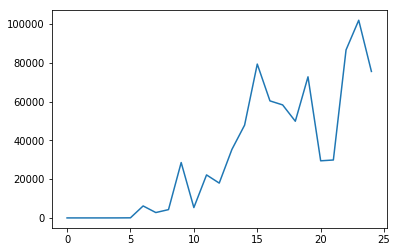

In [32]:
plt.plot(TPs)

In [33]:
# Load saved model
model = UNet1(ch_in=1, num_classes=2, nf=32)
model.load_state_dict(torch.load(path_trained_model))
if torch.cuda.is_available():
    model.cuda(GPU)

In [34]:
# lr=1e-5
opt = optim.Adam(model.parameters(), lr=lr)

In [35]:
# Get epochs from previous training
epoch_previous = int(path_trained_model.split('_')[-2].split('ep')[0])
epochs_more=25
range_new = np.arange(epoch_previous+1,epoch_previous+1+epochs_more)
range_new

array([26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42,
       43, 44, 45, 46, 47, 48, 49, 50])

In [ ]:
for epoch in range_new:

    epoch_loss = 0
    epoch_loss_val = 0

    for idx, (imgs, msks) in tqdm(enumerate(dataloader_train), desc='train batch', total = len(dataloader_train.dataset)//dataloader_train.batch_size):
        #if idx >= 1: continue                                # !!! REMOVE !!!
        start = time.time()
        model.train()
        
        TPs_batch_train, total_1_voxels_batch_train, TP_and_FN_batch_train = 0, 0, 0
#         print(f' inputs = {np.shape(imgs)}, {np.shape(msks)}')

        opt.zero_grad()    # Clear gradients w.r.t. parameters
        if torch.cuda.is_available():
            imgs = Variable(imgs.cuda(GPU))
            msks = Variable(msks.cuda(GPU))
        else:
            imgs = Variable(imgs)
            msks = Variable(msks)

        pred = model(imgs)
        # Check !!! if to use the dice coeff loss we round up the predictions
        #pred_class= torch.round(pred)
        #loss = dice_loss(pred, msks)
        loss = criterion(pred, msks.float())
        loss.backward()     # Getting gradients w.r.t. parameters
        opt.step()    # Updating parameters
        
        
        pred_arr_train = pred.detach().cpu().numpy()
        msks_arr_train = msks.detach().cpu().numpy()
        pred_arr_class_train = pred_arr_train > .5
        TP_train = np.sum(pred_arr_class_train * msks_arr_train)
        total_1s_train = np.sum(msks_arr_train)
        TPs_batch_train += TP_train
        total_1_voxels_batch_train += total_1s_train
        TP_and_FN_batch_train += np.sum(pred_arr_class_train)

        epoch_loss+=loss.item()
        
    # TEST
    model.eval()
    with torch.no_grad():
                
        TPs_batch, total_1_voxels_batch, TP_and_FN_batch = 0, 0, 0
        loss_val_epoch = 0
        for idx_val, (imgs_val, msks_val) in tqdm(enumerate(dataloader_test), desc='val batch',total = len(dataloader_test.dataset)//dataloader_test.batch_size):
            #if idx_val>=2:continue # !!!! REMOVE
            #print(idx, idx_val)

            if torch.cuda.is_available():
                imgs_val = Variable(imgs_val.cuda(GPU))
                msks_val = Variable(msks_val.cuda(GPU))
            else:
                imgs_val = Variable(imgs_val)
                msks_val = Variable(msks_val)

            pred_val = model(imgs_val)
            assert(np.shape(pred_val) == np.shape(msks_val))
            # Check !!! if to use the dice coeff loss we round up the predictions
            #pred_class_val= torch.round(pred_val)
            #loss_val = dice_loss(pred_val, msks_val)
            loss_val = criterion(pred_val, msks_val.float())
                    
            pred_arr = pred_val.detach().cpu().numpy()
            msks_arr = msks_val.detach().cpu().numpy()
            pred_arr_class = pred_arr > .5
            TP = np.sum(pred_arr_class * msks_arr)
            total_1s = np.sum(msks_arr)
            TPs_batch += TP
            total_1_voxels_batch += total_1s
                    
            #TP_perc = TP / total_1s
            TP_and_FN_batch += np.sum(pred_arr_class)
            #precision = TP/TP_and_FN
                    
            #TP_percs_batch.append(TP_perc)
            #precisions_batch.append(precision)

            epoch_loss_val+=loss_val.item()
                    
            #if idx_val ==1:break

    TPs.append(TPs_batch)
    TPs_train.append(TPs_batch_train)
    
    total_1_voxels.append(total_1_voxels_batch)
    total_1_voxels_train.append(total_1_voxels_batch_train)
    
    TP_and_FN.append(TP_and_FN_batch)
    TP_and_FN_train.append(TP_and_FN_batch_train)
    
    loss_test.append(epoch_loss_val/len(dataloader_test.dataset))
        
    loss_train.append(epoch_loss/len(dataloader_train.dataset))
    stop = time.time()
    
    if epoch % 5 == 0:
        path_trained_model = f'CNN models/UNet_4blocks_{epoch}ep_{version}.pt'
        torch.save(model.state_dict(), path_trained_model)

    print(f'epoch {epoch}, minibatch {idx} in {stop-start:.2f}s')

In [ ]:
# Save metrics
results_dict = {'loss_train':loss_train,
    'loss_test':loss_test,
    'TPs':TPs,
    'total_1_voxels':total_1_voxels,
    'TP_and_FN':TP_and_FN,
    'TPs_train':TPs_train,
    'total_1_voxels_train':total_1_voxels_train,
    'TP_and_FN_train':TP_and_FN_train}
path_results_dict = f'CNN models/results_dict_{epoch}ep_{version}'

with open(path_results_dict + '.pkl', 'wb') as f:
    pickle.dump(results_dict, f, pickle.HIGHEST_PROTOCOL)

In [ ]:
path_trained_model = f'CNN models/UNet_4blocks_{epoch}ep_{version}.pt'
torch.save(model.state_dict(), path_trained_model)

In [ ]:
path_trained_entire_model = path_trained_model[:-3] + '_entire_model.pt'
torch.save(model, path_trained_entire_model)

In [ ]:
plt.plot(TPs)
plt.plot(TP_and_FN)

# Evaluate

In [ ]:
# Get one scan
pred_sample = [f'{path_source}lungs/{i}' for i in files_test]
idname = 'LIDC-IDRI-0390'
pred_sample = [i for i in pred_sample if idname in i]
pred_sample = np.sort(pred_sample)

y_true = [f'{path_source}masks/{i}' for i in files_test]
y_true = [i for i in y_true if idname in i]
y_true = np.sort(y_true)
    
for i,j in zip(pred_sample, y_true): print(i.split('/')[-1],'   ', j.split('/')[-1])

In [ ]:
# Check which cubes have the nodule
for idx, i in enumerate(y_true):
    msk = np.load(i)
    msk = msk.f.arr_0
    z, y, x = np.where(msk==1)
    if len(z)>=1: print(idx, i)

In [ ]:
img = np.load(pred_sample[2])
img = img.f.arr_0
mask_true = np.load(y_true[2])
mask_true = mask_true.f.arr_0
# Preprocess
img = (img - MIN_BOUND) / (MAX_BOUND - MIN_BOUND)
img[img>1] = 1.
img[img<0] = 0.
img = img - PIXEL_MEAN
img = np.float32(img)

In [ ]:
img = np.expand_dims(img, 0) # add channel dimension
img = np.expand_dims(img, 0) # add batch dimension
img = Variable(torch.from_numpy(img).cuda(GPU))

In [ ]:
pred = model(img)
pred_np = pred[0][0].detach().cpu().numpy()
img_np = img[0][0].detach().cpu().numpy()
mask_true_np = mask_true[0][0]

In [ ]:
np.where(pred_np>.5)

In [ ]:
fig, ax = plt.subplots(1,3,figsize=(14,5))
ax[0].imshow(img_np[13])
ax[1].imshow(pred_np[13]>.5)
ax[2].imshow(mask_true[13])

In [ ]:
## Get metrics back
#path_results_dict_to_recover = f'CNN models/results_dict_{epoch_previous}ep'

#with open(path_results_dict_to_recover + '.pkl', 'rb') as f:
    #results_dict_recovered = pickle.load(f)
    
#loss_train_recovered = results_dict_recovered['loss_train']
#loss_test_recovered = results_dict_recovered['loss_test']
#TPs_recovered = results_dict_recovered['TPs']
#total_1_voxels_recovered = results_dict_recovered['total_1_voxels']
#TP_and_FN_recovered = results_dict_recovered['TP_and_FN']
#TPs_train_recovered = results_dict_recovered['TPs_train']
#total_1_voxels_train_recovered = results_dict_recovered['total_1_voxels_train']
#TP_and_FN_train_recovered = results_dict_recovered['TP_and_FN_train']

In [ ]:
#loss_train_recovered.append(loss_train)
#loss_test_recovered.append(loss_test)
#TPs_recovered.append(TPs)
#total_1_voxels_recovered.append(total_1_voxels)
#TP_and_FN_recovered.append(TP_and_FN)
#TPs_train_recovered.append(TPs_train)
#total_1_voxels_train_recovered.append(total_1_voxels_train)
#TP_and_FN_train_recovered.append(TP_and_FN_train)

In [ ]:
plt.figure()
plt.plot(TPs)
plt.plot(total_1_voxels)
plt.figure()
plt.plot(TP_and_FN)

In [ ]:
(pred_arr==1).all()

---